In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [00:08<00:00, 281MB/s]


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


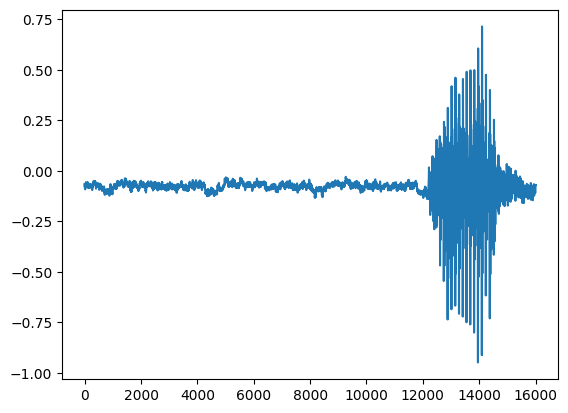

In [4]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [5]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [6]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [7]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [8]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [9]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [10]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [11]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [25]:
import torch.nn.functional as F

def train(model, epoch, log_interval):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # Ensure output shape is [batch_size, num_classes] (not [batch_size, 1, num_classes])
        if output.dim() == 3:  # Fix incorrect shape
            output = output.squeeze(1)  # Remove the extra dimension

        # Compute loss (negative log-likelihood loss)
        loss = F.nll_loss(output, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update total loss and correct predictions
        total_loss += loss.item()
        pred = output.argmax(dim=1)  # Get the predicted class index
        correct += pred.eq(target).sum().item()  # Fix shape mismatch
        total_samples += target.size(0)  # Ensure correct sample count

        # Print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # Update progress bar
        pbar.update(pbar_update)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total_samples

    return avg_loss, accuracy

In [26]:
import torch.nn.functional as F

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Apply transform and model on whole batch directly on device
            data = transform(data)
            output = model(data)

            # Ensure output shape is [batch_size, num_classes] (not [batch_size, 1, num_classes])
            if output.dim() == 3:  # Fix incorrect shape
                output = output.squeeze(1)  # Remove the extra dimension

            # Compute loss
            loss = F.nll_loss(output, target, reduction='sum')  # Sum loss for the batch
            test_loss += loss.item()  # Accumulate total test loss

            # Calculate number of correct predictions
            pred = get_likely_index(output)  # Now pred.shape = [batch_size]
            correct += number_of_correct(pred, target)  # Ensure correct shape
            total += target.size(0)

            # Update progress bar
            pbar.update(pbar_update)

    # Calculate average loss and accuracy for the test set
    avg_loss = test_loss / total
    accuracy = 100. * correct / total

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({accuracy:.2f}%)\n")

    # Return average loss and accuracy for this epoch
    return avg_loss, accuracy

In [27]:
import matplotlib.pyplot as plt
from tqdm import tqdm

log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        # Train the model and capture training loss and accuracy
        train_loss, train_accuracy = train(model, epoch, log_interval)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Test the model and capture test loss and accuracy
        test_loss, test_accuracy = test(model, epoch)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Step the scheduler
        scheduler.step()
        
        # Update progress bar
        pbar.update(1)

  0%|          | 0.0026666666666666666/2 [00:00<10:09, 305.21s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.752926


  3%|▎         | 0.05599999999999999/2 [00:17<09:58, 307.91s/it]  

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.622599


  5%|▌         | 0.10933333333333328/2 [00:33<09:44, 309.05s/it] 

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.749225


  8%|▊         | 0.16266666666666676/2 [00:50<09:20, 304.83s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.831605


 11%|█         | 0.21600000000000033/2 [01:06<09:08, 307.67s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.914343


 13%|█▎        | 0.2693333333333337/2 [01:23<08:49, 305.67s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.705681


 16%|█▌        | 0.3226666666666667/2 [01:39<08:35, 307.07s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.784295


 19%|█▉        | 0.3759999999999997/2 [01:55<08:17, 306.48s/it] 

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.800769


 21%|██▏       | 0.42933333333333273/2 [02:12<08:07, 310.41s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.675229


 24%|██▍       | 0.48266666666666574/2 [02:28<07:53, 312.33s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.778355


 27%|██▋       | 0.5359999999999995/2 [02:45<07:26, 305.13s/it] 

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.960519


 29%|██▉       | 0.5893333333333336/2 [03:01<07:24, 315.37s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.922913


 32%|███▏      | 0.6426666666666677/2 [03:17<06:58, 308.11s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.644648


 35%|███▍      | 0.6960000000000018/2 [03:34<06:44, 310.17s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.818356


 37%|███▋      | 0.749333333333336/2 [03:50<06:22, 305.95s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.711375


 40%|████      | 0.8026666666666701/2 [04:07<06:12, 310.97s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.663142


 43%|████▎     | 0.8560000000000042/2 [04:23<05:49, 305.90s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.689282


 50%|█████     | 1.0000000000000062/2 [05:05<04:47, 287.81s/it]


Test Epoch: 1	Accuracy: 8249/11005 (74.96%)



/opt/conda/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 2.002666666666673/2 [05:06<00:00,  2.70s/it]  

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.684357


102%|██████████| 2.0400000000000085/2 [05:17<00:00, 18.38s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.636379


105%|██████████| 2.106666666666679/2 [05:38<-1:59:51, 85.86s/it] 

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.699992


108%|██████████| 2.162666666666682/2 [05:55<-1:59:12, 299.47s/it] 

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.543136


111%|██████████| 2.2160000000000184/2 [06:12<-1:58:53, 312.06s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.757342


113%|██████████| 2.2693333333333547/2 [06:28<-1:58:38, 307.74s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.792013


116%|██████████| 2.322666666666691/2 [06:44<-1:58:22, 305.92s/it] 

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.676972


119%|██████████| 2.3760000000000274/2 [07:01<-1:58:05, 305.93s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.710950


121%|██████████| 2.4293333333333638/2 [07:17<-1:57:47, 310.57s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.658651


124%|██████████| 2.4826666666667/2 [07:33<-1:57:32, 306.71s/it]   

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.743885


2.5360000000000364it [07:50, 307.39s/it]                          

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.746652


2.589333333333373it [08:06, 308.80s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.700046


2.642666666666709it [08:23, 308.27s/it] 

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.844297


2.6960000000000455it [08:39, 308.33s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.734554


2.749333333333382it [08:57, 346.80s/it] 

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.673200


2.802666666666718it [09:15, 335.50s/it] 

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.738145


2.8560000000000545it [09:32, 306.20s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.751289


4.000000000000062it [10:14, 153.54s/it] 


Test Epoch: 2	Accuracy: 8525/11005 (77.46%)



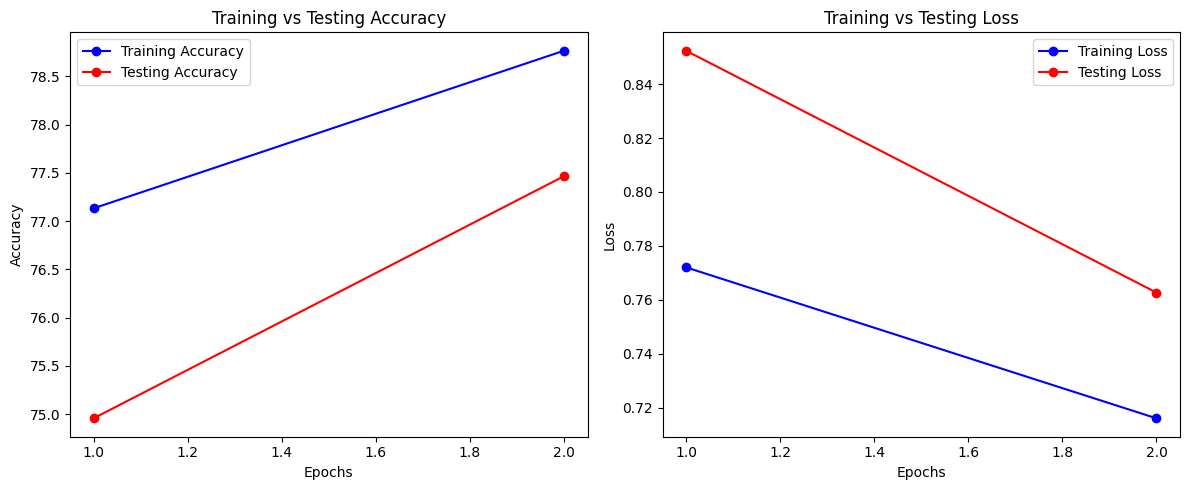

In [28]:
# Plotting Training vs Testing Accuracy and Loss
epochs = range(1, n_epoch + 1)

plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'ro-', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, test_losses, 'ro-', label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

In [ ]:
def record(seconds=1):
    !pip install pydub # install the module

    import sys
    import torchaudio
    import IPython.display as ipd
    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)